# Data Preprocessing

## Import necessary modules

In [57]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("../") 
import pandas as pd
# Data processing modules
import category_encoders as ce
from sklearn.preprocessing import StandardScaler

# Import custom modules
from src.data.data_ingestion import ingest_raw_data
from src.utils.visualization import plot_non_missing_story_points_distribution, plot_boxplot, plot_correlation_matrix
from src.data.data_processing import missing_value_statistics, log_transform_outliers, remove_duplicates, identify_outliers, assess_unique_values, save_processed_data

## Data Loading

### Ingest raw data from MySql database

In [58]:
raw_data = ingest_raw_data()

[2023-09-07 20:15:34,305] 26 src.utils.logger - INFO - Started data ingestion process...
[2023-09-07 20:15:34,307] 29 src.utils.logger - INFO - Data already ingested to CSV: /home/umar/Workspace/personal/msc-dissertation/src/data/../../data/raw/raw.csv


### Load raw data into a data frame

In [59]:
# Load the dataset
data = pd.read_csv(raw_data)

# Display the first few rows to inspect the structure
data.head()

/tmp/ipykernel_6704/3295681787.py:2: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(raw_data)


,ID,Jira_ID,Issue_Key,URL,Title,Description,Description_Text,Description_Code,Type,Priority,...,Resolution_Time_Minutes,Title_Changed_After_Estimation,Description_Changed_After_Estimation,Story_Point_Changed_After_Estimation,Pull_Request_URL,Creator_ID,Reporter_ID,Assignee_ID,Project_ID,Sprint_ID
0,65,77638,XD-3768,https://jira.spring.io/rest/api/2/issue/77638,"""How do I make a job restartable in spring xd""","""The jobs that appear under Executions section...","""""""The jobs that appear under Executions secti...",NaN,Bug,Major,...,0.0,0,0,0,NaN,68.0,68.0,NaN,1,NaN
1,66,77511,XD-3767,https://jira.spring.io/rest/api/2/issue/77511,"""admin config timezone command does not work""","""Working with Spring-XD version 1.3.2.RELEASE ...","""""""Working with Spring-XD version 1.3.2.RELEAS...",""" xd:>admin config admin config info ad...",Bug,Trivial,...,0.0,0,0,0,NaN,69.0,69.0,NaN,1,NaN
2,67,77130,XD-3766,https://jira.spring.io/rest/api/2/issue/77130,"""Module Upload command not pushing jar to all ...","""My project 7 node cluster and in that 2 node ...","""""""My project 7 node cluster and in that 2 nod...",NaN,Bug,Major,...,0.0,0,0,0,NaN,70.0,70.0,NaN,1,NaN
3,68,71950,XD-3765,https://jira.spring.io/rest/api/2/issue/71950,"""Fix stream failover ""","""See https://github.com/spring-projects/spring...","""""""See https://github.com/spring-projects/spri...",NaN,Story,Minor,...,0.0,1,0,0,NaN,72.0,72.0,71.0,1,NaN
4,69,71805,XD-3764,https://jira.spring.io/rest/api/2/issue/71805,"""SpringXD Job is still executing even after fo...","""I'm trying to run a Job on SpringXD and the j...","""""""I'm trying to run a Job on SpringXD and the...",NaN,Bug,Major,...,0.0,0,0,0,NaN,73.0,73.0,NaN,1,NaN


## Data cleaning

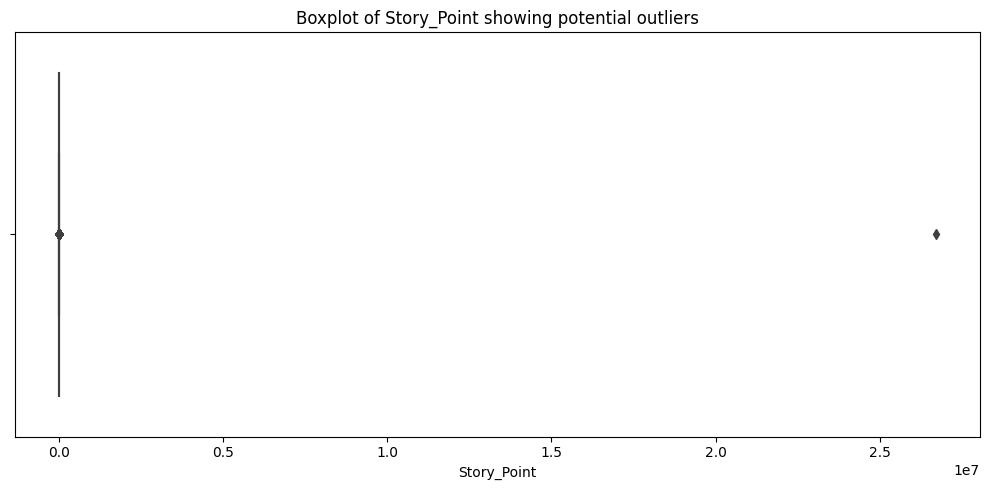

In [60]:
# Plot boxplots Story_Point
plot_boxplot(data=data, feature='Story_Point', title='Boxplot of Story_Point showing potential outliers')

In [61]:
# List of numerical columns to check for outliers
columns_to_check_for_outliers = ['Story_Point']
outliers_stats = identify_outliers(data, columns_to_check_for_outliers)

Story_Point: 1.0961696258663733


In [62]:
# Apply logarithmic transformation to the columns
data = log_transform_outliers(data, columns_to_check_for_outliers)

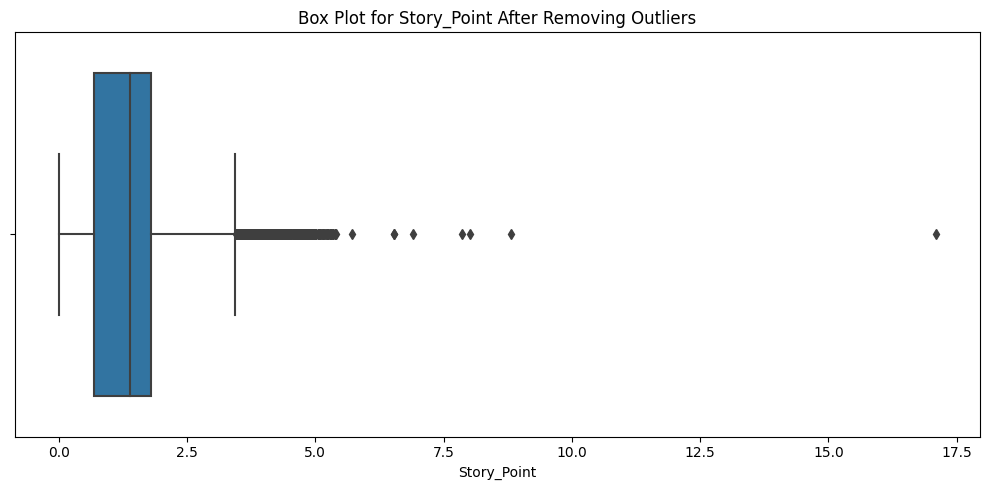

In [63]:
# Visualize the transformed distributions
plot_boxplot(data=data, feature='Story_Point', title='Box Plot for Story_Point After Removing Outliers')

In [64]:
outliers_stats_after_log_transformation = identify_outliers(data, columns_to_check_for_outliers)

Story_Point: 0.2965746608704761


In [65]:
# Check missing values
missing_value_statistics(data)

,Missing Values,Percentage
Pull_Request_URL,457586,99.859023
Timespent,447989,97.764669
Sprint_ID,414757,90.512448
Description_Code,399227,87.123335
Estimation_Date,392805,85.721861
Story_Point,392805,85.721861
Assignee_ID,196401,42.860603
Priority,126659,27.640802
Resolution_Date,105600,23.045095
Resolution,77498,16.912394


In [66]:
# Drop the top two columns with the highest missing values and irrelevant column 'URL'
data.drop(columns=['Timespent', 'Pull_Request_URL', 'URL'], axis=1, inplace=True)

In [67]:
# Convert date columns to datetime format
date_columns = ['Creation_Date', 'Estimation_Date', 'Resolution_Date', 'Last_Updated']
for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')

# Check the data types again to confirm conversion
data[date_columns].dtypes

Creation_Date      datetime64[ns]
Estimation_Date    datetime64[ns]
Resolution_Date    datetime64[ns]
Last_Updated       datetime64[ns]
dtype: object

In [68]:
columns_to_fill_with_negative = ['Sprint_ID', 'Reporter_ID', 'Creator_ID', 'Jira_ID', 'Assignee_ID']

# Impute missing values for ID columns, with -1
for column in columns_to_fill_with_negative:
    data[column].fillna(-1, inplace=True)

In [69]:
# Impute missing values for 'Priority'
data['Priority'].fillna('Unknown', inplace=True)

# Impute missing values for 'Resolution'
data['Resolution'].fillna('Unknown', inplace=True)

# Impute missing values for 'Estimation_Date' with 'Creation_Date'
data['Estimation_Date'] = data['Estimation_Date'].fillna(data['Creation_Date'])

# Impute missing values for Description columns
data['Description'].fillna('No description', inplace=True)
data['Description_Text'].fillna('No description text', inplace=True)
data['Description_Code'].fillna('No description code', inplace=True)

In [70]:
# Check remaining missing values
missing_value_statistics(data)

,Missing Values,Percentage
Story_Point,392805,85.721861
Resolution_Date,105600,23.045095


In [71]:
# Create a binary column 'Has_Resolution_Date' and drop the original 'Resolution_Date'
data['Has_Resolution_Date'] = data['Resolution_Date'].notna().astype(int)
data.drop(columns='Resolution_Date', inplace=True)

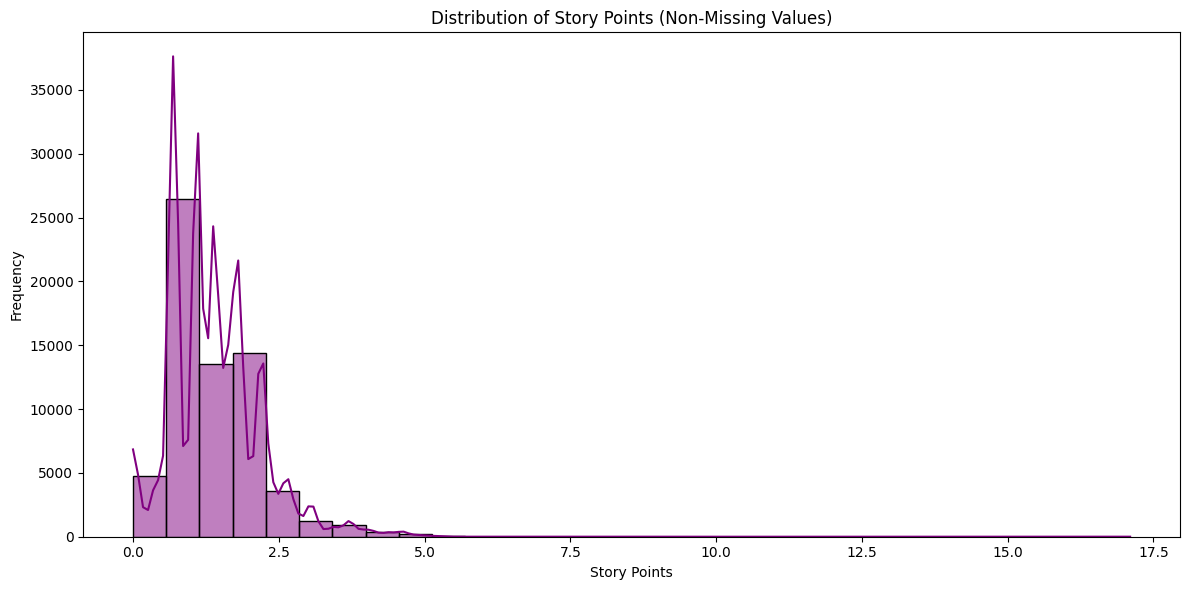

In [72]:
# Plot distribution of story points for non-missing values
plot_non_missing_story_points_distribution(data)

In [73]:
# Impute missing values for 'Story_Point' with its median
data['Story_Point'].fillna(data['Story_Point'].median(), inplace=True)

In [74]:
# Check if there are any remaining missing values
missing_value_statistics(data)

,Missing Values,Percentage


In [75]:
remove_duplicates(data)

Duplicate rows removed: 0


## Feature Engineering

### Feature Extraction

In [76]:
# Extract the time difference between Creation_Date and Estimation_Date
data['Time_To_Estimate_Minutes'] = (data['Estimation_Date'] - data['Creation_Date']).dt.days

In [77]:
# Extract text-based features for 'Title' and 'Description' columns
issue_text_columns = ['Title', 'Description', 'Description_Text', 'Description_Code']
new_columns = []

for column in issue_text_columns:
    # Length of the text
    length_column = f'{column}_Length'
    data[length_column] = data[column].apply(len)
    new_columns.append(length_column)
    # Number of unique words
    unique_words_column = f'{column}_Unique_Words'
    data[unique_words_column] = data[column].apply(lambda x: len(set(x.split())))
    new_columns.append(unique_words_column)

# Check the first few rows to verify the new columns
data[new_columns].head()

,Title_Length,Title_Unique_Words,Description_Length,Description_Unique_Words,Description_Text_Length,Description_Text_Unique_Words,Description_Code_Length,Description_Code_Unique_Words
0,46,10,130,24,134,24,19,3
1,45,7,1027,68,370,46,639,31
2,57,9,549,66,557,66,19,3
3,22,4,62,2,66,2,19,3
4,69,10,1161,114,1177,114,19,3


### Categorical Encoding

In [78]:
categorical_columns = ['Type', 'Priority', 'Status', 'Resolution']
unique_values_statistics = assess_unique_values(data, categorical_columns)
print(unique_values_statistics)

Type          24
Priority      17
Status        76
Resolution    55
dtype: int64


In [79]:
# Binary encoding for 'Status' and 'Resolution'
binary_encoder = ce.BinaryEncoder(cols=['Status', 'Resolution'])
data = binary_encoder.fit_transform(data)

# One-Hot encoding for 'Type' and 'Priority'
data = pd.get_dummies(data, columns=['Type', 'Priority'], drop_first=True)

In [80]:
data.head()

,ID,Jira_ID,Issue_Key,Title,Description,Description_Text,Description_Code,Status_0,Status_1,Status_2,...,Priority_Lowest,Priority_Major,Priority_Major - P3,Priority_Medium,Priority_Minor,Priority_Minor - P4,Priority_To be reviewed,Priority_Trivial,Priority_Trivial - P5,Priority_Unknown
0,65,77638,XD-3768,"""How do I make a job restartable in spring xd""","""The jobs that appear under Executions section...","""""""The jobs that appear under Executions secti...",No description code,0,0,0,...,False,True,False,False,False,False,False,False,False,False
1,66,77511,XD-3767,"""admin config timezone command does not work""","""Working with Spring-XD version 1.3.2.RELEASE ...","""""""Working with Spring-XD version 1.3.2.RELEAS...",""" xd:>admin config admin config info ad...",0,0,0,...,False,False,False,False,False,False,False,True,False,False
2,67,77130,XD-3766,"""Module Upload command not pushing jar to all ...","""My project 7 node cluster and in that 2 node ...","""""""My project 7 node cluster and in that 2 nod...",No description code,0,0,0,...,False,True,False,False,False,False,False,False,False,False
3,68,71950,XD-3765,"""Fix stream failover ""","""See https://github.com/spring-projects/spring...","""""""See https://github.com/spring-projects/spri...",No description code,0,0,0,...,False,False,False,False,True,False,False,False,False,False
4,69,71805,XD-3764,"""SpringXD Job is still executing even after fo...","""I'm trying to run a Job on SpringXD and the j...","""""""I'm trying to run a Job on SpringXD and the...",No description code,0,0,0,...,False,True,False,False,False,False,False,False,False,False


### Feature Scaling

In [81]:
features_to_scale = [
    'Title_Length', 'Title_Unique_Words',
    'Description_Length', 'Description_Unique_Words',
    'Description_Text_Length', 'Description_Text_Unique_Words',
    'Description_Code_Length', 'Description_Code_Unique_Words'
]

# Apply standardization
scaler = StandardScaler()
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])

### Save Processed Data

In [82]:
# Drop non-numeric columns
numeric_data = data.select_dtypes(include=[float, int])

In [83]:
# save processed data for use in Model development
save_processed_data(numeric_data)

[2023-09-07 20:16:11,167] 110 src.utils.logger - INFO - Data successfully saved to CSV: /home/umar/Workspace/personal/msc-dissertation/src/data/../../data/processed/processed.csv


## Correlation Analysis with Pearson correlation coefficient

In [84]:
# Drop non-numeric columns
numeric_data = data.select_dtypes(include=[float, int])

# Compute the correlation with 'Story_Point'
correlations = numeric_data.corr()['Story_Point'].drop('Story_Point')

# Display the top 10 features with the highest absolute correlation
top_correlations = correlations.abs().sort_values(ascending=False).head(10)
print(top_correlations)

Story_Point_Changed_After_Estimation    0.136694
In_Progress_Minutes                     0.078277
Sprint_ID                               0.056332
Status_4                                0.050915
Time_To_Estimate_Minutes                0.050140
Title_Changed_After_Estimation          0.045239
Total_Effort_Minutes                    0.044463
Project_ID                              0.035632
Resolution_5                            0.034962
ID                                      0.021872
Name: Story_Point, dtype: float64


### Plot correlation matrix

[2023-09-07 20:16:12,877] 876 matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x7f0b9594c640>


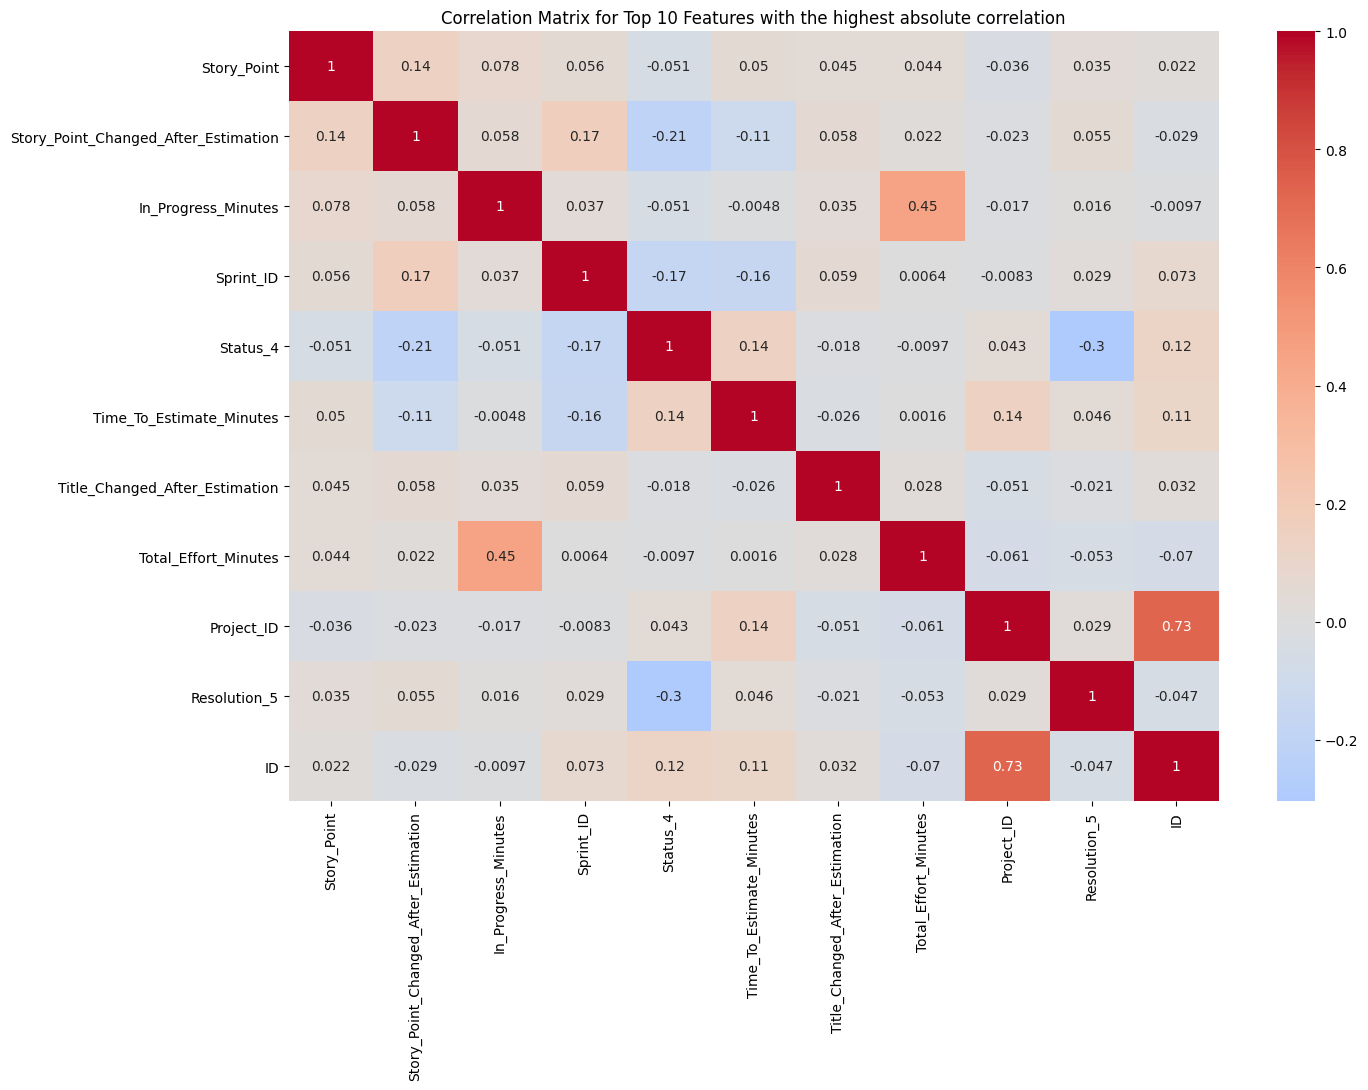

In [85]:
top_features = top_correlations.index.insert(0, 'Story_Point')

# Compute the correlation matrix for the top features
correlation_matrix = data[top_features].corr()

# Plot the heatmap
plot_correlation_matrix(correlation_matrix, 'Correlation Matrix for Top 10 Features with the highest absolute correlation')